<a href="https://colab.research.google.com/github/eyalgur1/Asynchronous_ToA_Source_Localization/blob/main/UNET_optimize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import torch
from torch import nn
import numpy as np


class UNet(nn.Module):
    """
    U-Net Architecture for Image Segmentation.
    This architecture consists of an encoder (contracting path) and a decoder (expanding path)
    with skip connections between corresponding layers to preserve spatial information.
    U-Net requires that the input size is divisible by 2^n, where n is the number of down-sampling layers in the network.
    This ensures the up-sampled feature maps can align with the encoder's feature maps for skip connections.
    """

    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        """
        Initialize the U-Net model.

        Args:
        - in_channels (int): Number of input channels (e.g., 3 for RGB images).
        - out_channels (int): Number of output channels (e.g., 1 for binary segmentation).
        """
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)  # First convolution block
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # Downsample 1
        self.enc2 = self.conv_block(64, 128)  # Second convolution block
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # Downsample 2
        self.enc3 = self.conv_block(128, 256)  # Third convolution block
        self.pool3 = nn.MaxPool2d(kernel_size=2)  # Downsample 3
        self.enc4 = self.conv_block(256, 512)  # Fourth convolution block

        # Decoder
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)  # Upsample + reduce channels
        self.dec3 = self.conv_block(512, 256)  # Concatenate + convolution block
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        # Final 1x1 Convolution
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """
        Double Convolution Block: (Conv2d -> ReLU) * 2
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        """
        Forward pass through the U-Net model.
        """

        # Encoder path
        e1 = self.enc1(x)  # [B, 64, 128, 128]
        p1 = self.pool1(e1)  # [B, 64, 64, 64]

        e2 = self.enc2(p1)  # [B, 128, 64, 64]
        p2 = self.pool2(e2)  # [B, 128, 32, 32]

        e3 = self.enc3(p2)  # [B, 256, 32, 32]
        p3 = self.pool3(e3)  # [B, 256, 16, 16]

        e4 = self.enc4(p3)  # [B, 512, 16, 16]

        # Decoder path
        up3 = self.up3(e4)  # Upsample e4 to [B, 256, 32, 32]
        d3 = self.dec3(torch.cat([up3, e3], dim=1))  # Concatenate with e3

        up2 = self.up2(d3)  # Upsample d3 to [B, 128, 64, 64]
        d2 = self.dec2(torch.cat([up2, e2], dim=1))  # Concatenate with e2

        up1 = self.up1(d2)  # Upsample d2 to [B, 64, 128, 128]
        d1 = self.dec1(torch.cat([up1, e1], dim=1))  # Concatenate with e1

        # Final output layer
        out = self.final_conv(d1)  # [B, out_channels, 128, 128]

        return out

    def get_encoder_decoder_params(self):
        """
        Divide the U-Net parameters into encoder and decoder groups.
        This will be used to set up separate optimizers for NAM.

        Returns:
        - encoder_params: Parameters of the encoder.
        - decoder_params: Parameters of the decoder.
        """
        # Collect all parameters from encoder layers
        encoder_params = list(self.enc1.parameters()) + \
                         list(self.enc2.parameters()) + \
                         list(self.enc3.parameters()) + \
                         list(self.enc4.parameters())

        # Collect all parameters from decoder layers, including final output layer
        decoder_params = list(self.dec3.parameters()) + \
                         list(self.dec2.parameters()) + \
                         list(self.dec1.parameters()) + \
                         list(self.up3.parameters()) + \
                         list(self.up2.parameters()) + \
                         list(self.up1.parameters()) + \
                         list(self.final_conv.parameters())

        return encoder_params, decoder_params


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, outputs, targets):
        outputs = torch.sigmoid(outputs)  # Convert logits to probabilities
        # Debugging: Check the range of outputs
        outputs = outputs.view(-1)  # Flatten
        targets = targets.view(-1)  # Flatten

        intersection = (outputs * targets).sum()
        union = outputs.sum() + targets.sum()

        dice_coefficient = (2.0 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice_coefficient

        return dice_loss


class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceBCELoss, self).__init__()
        self.dice_loss = DiceLoss(smooth)
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, outputs, targets):
        dice = self.dice_loss(outputs, targets)
        bce = self.bce_loss(outputs, targets)
        return dice + bce


def set_seed(seed):
    """
    Set the random seed for reproducibility.
    Args:
    - seed (int): The random seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed(seed)  # For current GPU
    torch.cuda.manual_seed_all(seed)  # If using multiple GPUs
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False     # Disable CuDNN optimization for determinism


In [111]:
import torch.nn as nn
import torch.optim as optim
import random
import time  # For runtime tracking


def switch_requires_grad(decoder_params, encoder_params, optimize_encoder):  # switch requires_grad for model object containing encoder and decoder
    if optimize_encoder:
        for p in decoder_params:
            p.requires_grad = False
        for p in encoder_params:
            p.requires_grad = True
    else:
        for p in encoder_params:
            p.requires_grad = False
        for p in decoder_params:
            p.requires_grad = True


def train_model(
        model, train_loader, val_loader, num_epochs, device,
        optimizer_type="adam", lr_encoder=1e-3, lr_decoder=1e-3, alternating_strategy="epoch"
):
    """
    Generalized training function for U-Net with NAM or standard ADAM optimization.
    Training loss is displayed for each batch, and colors can alternate for NAM models.

    Args:
    - model: The U-Net model.
    - train_loader: DataLoader for the training dataset.
    - val_loader: DataLoader for the validation dataset.
    - num_epochs: Total number of epochs.
    - device: Device (CPU or GPU).
    - optimizer_type: "adam" for standard ADAM or "nam" for NAM optimization.
    - lr_encoder: Learning rate for the encoder (used in NAM).
    - lr_decoder: Learning rate for the decoder (used in NAM).
    - alternating_strategy: Strategy for alternating optimization ("epoch" or "batch").

    Returns:
    - Trained model and training history (loss and IoU).
    """
    # Define loss function
    #criterion = nn.BCEWithLogitsLoss()
    criterion = DiceBCELoss()

    # Move the model to the specified device
    model = model.to(device)

    # Track loss and IoU
    history = {'train_loss': [], 'train_optimizer': [], 'val_loss': [], 'val_iou': []}

    # Compute and log initial loss before any updates
    # model.eval()  # Set model to evaluation mode for initial loss computation
    # with torch.no_grad():
    #     first_batch = next(iter(train_loader))
    #     images, masks = first_batch
    #     images, masks = images.to(device), masks.to(device)
    #     outputs = model(images)
    #     initial_loss = criterion(outputs, masks).item()
    #     print(f"[{optimizer_type.upper()}] Initial Loss: {initial_loss:.4f}")
    #     history['train_loss'].append(initial_loss)
    #     if optimizer_type == "nam":
    #         history['train_optimizer'].append("decoder")  # Currently we always start from decoder

    # Prepare optimizers
    if optimizer_type == "nam":
        encoder_params, decoder_params = model.get_encoder_decoder_params()
        encoder_optimizer = optim.Adam(encoder_params, lr=lr_encoder)
        decoder_optimizer = optim.Adam(decoder_params, lr=lr_decoder)
    elif optimizer_type == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr_encoder)

    model.train()  # Set model to training mode

    # Initialize timers for total training runtime
    total_training_time = 0  # Total time for training across all epochs

    for epoch in range(num_epochs):
        print(f"[{optimizer_type.upper()}] Epoch {epoch + 1}/{num_epochs}")

        epoch_training_start = time.time()  # Start timing the training portion of the epoch

        if optimizer_type == "nam":
            optimize_encoder = not (epoch % 2 == 0) if alternating_strategy == "epoch" else False
            switch_requires_grad(decoder_params, encoder_params, optimize_encoder)

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            if optimizer_type == "nam":
                # Reset gradients
                if not optimize_encoder:
                    decoder_optimizer.zero_grad()  # clear the gradients of all decoder parameters
                else:
                    encoder_optimizer.zero_grad()  # clear the gradients of all encoder parameters

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()  # calculate partial_L/partial_x for all parameters

                # Backward pass and optimization
                if optimize_encoder:
                    encoder_optimizer.step()
                    optimizer_name = "encoder"
                else:
                    decoder_optimizer.step()
                    optimizer_name = "decoder"

                # Alternate optimizer in batch-wise strategy
                if alternating_strategy == "batch":
                    optimize_encoder = not optimize_encoder
                    switch_requires_grad(decoder_params, encoder_params, optimize_encoder)
            else:
                # Standard ADAM optimization
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                optimizer_name = "adam"

            # Track batch-wise loss and optimizer
            history['train_loss'].append(loss.item())
            history['train_optimizer'].append(optimizer_name)

            # Print batch loss
            print(f"[{optimizer_type.upper()}] Batch {batch_idx + 1}, Loss: {loss.item():.4f}")

        epoch_training_end = time.time()  # End timing the training portion
        epoch_training_time = epoch_training_end - epoch_training_start
        total_training_time += epoch_training_time  # Accumulate total training time

        print(f"Epoch {epoch + 1} training runtime: {epoch_training_time:.2f} seconds")

        # Validation
        val_loss, val_iou = evaluate(model, val_loader, device, criterion)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)

        print(f"[{optimizer_type.upper()}] Validation - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}")

    print(f"Total training runtime (excluding validation): {total_training_time:.2f} seconds")
    print(f"Training complete with {optimizer_type.upper()} optimization.")
    return model, history


In [112]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation


class VOCSegmentationCustom(VOCSegmentation):
    # The parent class expects the arguments root, year, image_set, download, and they are passed directly to the child.
    def __init__(self, root, year="2012", image_set="train", download=False, image_size=(128, 128), binary_class=True):
        super().__init__(root=root, year=year, image_set=image_set, download=download)
        self.binary_class = binary_class

        # Define transformations
        self.transform_image = transforms.Compose([
            transforms.Resize(image_size),  # Resize image to fixed size
            transforms.ToTensor(),  # Convert image to tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
        ])
        self.transform_mask = transforms.Compose([
            transforms.Resize(image_size),  # Resize mask to fixed size
            transforms.ToTensor()  # Convert mask to tensor
        ])

    def __getitem__(self, index):
        # Retrieve the image and mask using the parent class's __getitem__ method
        image, mask = super().__getitem__(index)
        image = self.transform_image(image)  # Apply image transformations
        mask = self.transform_mask(mask)  # Apply mask transformations

        if self.binary_class:
            # Convert mask to binary (foreground/background)
            mask = (mask > 0).float()

        return image, mask


def prepare_dataloader(batch_size=8, image_size=(128, 128), binary_class=True, download_data=False):
    """mage_size=(128, 128)
    Prepares the Pascal VOC dataset and returns DataLoaders for training and validation.

    Args:
    - batch_size: Number of samples per batch.
    - image_size: Tuple (height, width) for resizing images and masks.
    - binary_class: If True, convert masks to binary (foreground vs. background).

    Returns:
    - train_loader: DataLoader for training data.
    - val_loader: DataLoader for validation data.
    """
    # Load Pascal VOC dataset (train and validation splits)
    train_dataset = VOCSegmentationCustom(
        root="./data", year="2012", image_set="train", download=download_data, image_size=image_size, binary_class=binary_class
    )
    val_dataset = VOCSegmentationCustom(
        root="./data", year="2012", image_set="val", download=download_data, image_size=image_size, binary_class=binary_class
    )

    # Create DataLoaders
    # The DataLoader iterates over the dataset in batches.
    # For each batch, it calls the dataset’s __getitem__ method for the corresponding indices.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    # num_workers parameter specifies the number of subprocesses (child processes) used for data loading.
    # These child processes work in parallel to load and preprocess batches of data while the main process runs the training loop.

    return train_loader, val_loader


In [113]:
import torch
import matplotlib.pyplot as plt
import os


def evaluate(model, loader, device, criterion):
    """
    Evaluate the model on a given DataLoader.

    Args:
    - model: The U-Net model.
    - loader: DataLoader (validation or training).
    - device: Device (CPU or GPU).
    - criterion: Loss function.

    Returns:
    - Average loss and mean IoU for the dataset.
    """
    model.eval()  # Ensures the model behaves correctly for evaluation (e.g., no dropout, correct batch norm).
    running_loss = 0.0
    iou_scores = []

    with torch.no_grad():  # Ensures that we do not compute or store gradients, which are unnecessary for evaluation.
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Convert outputs and masks to binary
            predictions = torch.sigmoid(outputs) > 0.5  # Sigmoid to get probabilities, threshold at 0.5
            masks = masks > 0.5

            # Compute IoU by summing over dimensions (1,2,3), i.e., for [batch_size,channels,height,width] we sum for the batches
            intersection = (predictions & masks).sum((1, 2, 3)).float()
            union = (predictions | masks).sum((1, 2, 3)).float()
            iou = (intersection / (union + 1e-6)).mean()

            running_loss += loss.item()
            iou_scores.append(iou.item())

    avg_loss = running_loss / len(loader)
    avg_iou = sum(iou_scores) / len(iou_scores)
    return avg_loss, avg_iou


def plot_training_and_validation(history_nam, history_adam, output_dir="./results"):
    """
    Plot training loss, validation loss, and validation IoU for NAM and ADAM on the same figure.

    Args:
    - history_nam: Training history dictionary for NAM optimizer, containing 'train_loss', 'val_loss', and 'val_iou'.
    - history_adam: Training history dictionary for ADAM optimizer, containing 'train_loss', 'val_loss', and 'val_iou'.
    - output_dir: Directory to save the figures.
    """
    os.makedirs(output_dir, exist_ok=True)  # Ensure the directory exists
    plt.figure(figsize=(15, 10))

    # Plot training loss
    plt.subplot(2, 1, 1)

    # NAM training loss with seamless line connections
    colors = {'encoder': 'blue', 'decoder': 'green'}
    current_segment_start = 0  # Start of the current segment
    for i in range(1, len(history_nam['train_loss'])):
        # Check for optimizer switch
        if history_nam['train_optimizer'][i] != history_nam['train_optimizer'][i - 1]:
            # Plot the current segment, including the first point of the next segment
            plt.plot(
                range(current_segment_start, i + 1),
                history_nam['train_loss'][current_segment_start:i + 1],
                color=colors[history_nam['train_optimizer'][i - 1]],
                linestyle='-',
                label=f"{history_nam['train_optimizer'][i - 1].capitalize()} Loss (NAM)" if current_segment_start == 0 else None
            )
            current_segment_start = i  # Start a new segment
    # Plot the final segment
    plt.plot(
        range(current_segment_start, len(history_nam['train_loss'])),
        history_nam['train_loss'][current_segment_start:],
        color=colors[history_nam['train_optimizer'][-1]],
        linestyle='-',
        label=f"{history_nam['train_optimizer'][-1].capitalize()} Loss (NAM)" if current_segment_start == 0 else None
    )

    # ADAM training loss
    plt.plot(
        range(len(history_adam['train_loss'])),
        history_adam['train_loss'],
        label="Training Loss (ADAM)",
        color='red',
        linestyle='-'
    )

    plt.xlabel("Batch Index")
    plt.ylabel("Loss")
    plt.title("Training Loss (NAM vs. ADAM)")
    plt.legend()

    # Plot validation loss and IoU
    plt.subplot(2, 1, 2)
    epochs_nam = range(1, len(history_nam['val_loss']) + 1)
    epochs_adam = range(1, len(history_adam['val_loss']) + 1)

    # NAM validation metrics
    plt.plot(epochs_nam, history_nam['val_loss'], label="Validation Loss (NAM)", color='orange', linestyle='-')
    plt.plot(epochs_nam, history_nam['val_iou'], label="Validation IoU (NAM)", color='purple', linestyle='-')

    # ADAM validation metrics
    plt.plot(epochs_adam, history_adam['val_loss'], label="Validation Loss (ADAM)", color='brown', linestyle='--')
    plt.plot(epochs_adam, history_adam['val_iou'], label="Validation IoU (ADAM)", color='pink', linestyle='--')

    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.title("Validation Loss and IoU (NAM vs. ADAM)")
    plt.legend()

    # Save and display the plot
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "NAM_vs_ADAM_metrics.png"))
    plt.show()


def count_trainable_params(params):
    """
    Count the number of trainable parameters in a list of parameters.
    """
    return sum(p.numel() for p in params) # Includes non-trainable paramters, otherwise set `if p.required_grad`


Preparing DataLoaders...

Initial weights are identical for both models!

Printing UNet Model Architecture...
UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3):

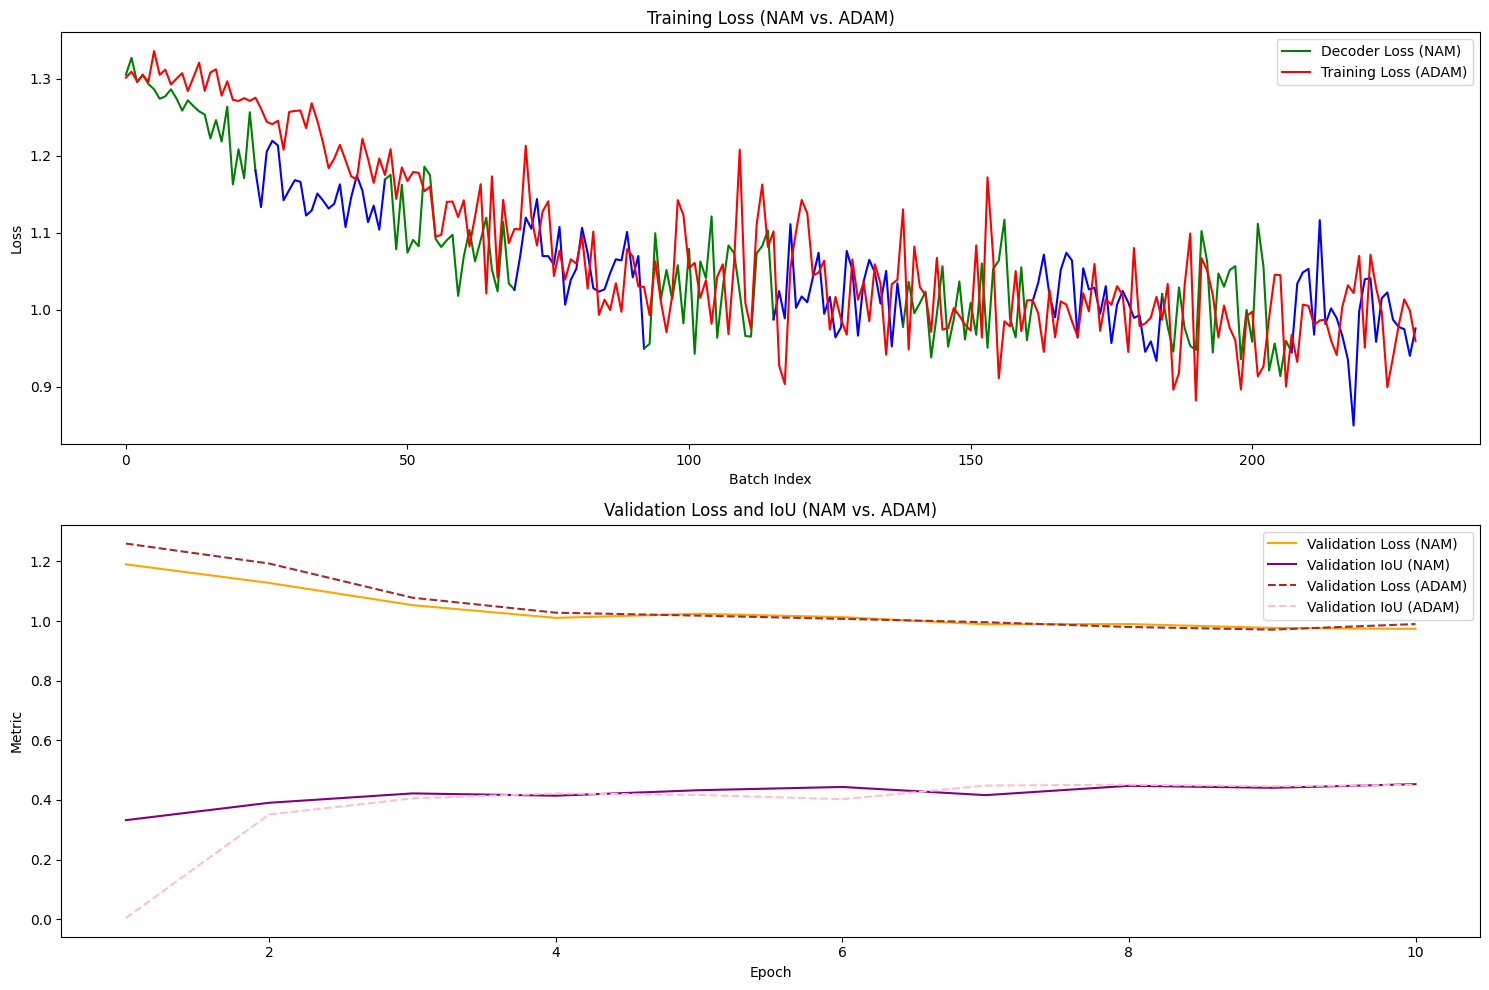


Final Validation Results:
NAM Optimization - Final Validation Loss: 0.9737, Final Validation IoU: 0.4529
ADAM Optimization - Final Validation Loss: 0.9898, Final Validation IoU: 0.4505
Total trainable parameters (ADAM): 7697345
Trainable parameters (NAM Encoder): 4685376
Trainable parameters (NAM Decoder): 3011969


In [114]:
import torch


if __name__ == '__main__':
    """
    The main process runs the training script and uses child processes to load batches of data in parallel.
    These child processes are created when you set num_workers > 0 in the DataLoader.
    When we use multiprocessing (e.g., via PyTorch’s DataLoader with num_workers > 0),
    Python needs to spawn child processes. On Windows, these child processes start fresh Python interpreters,
    which then re-import the script to know what code to execute. Hence, without the if __name__ == '__main__': guard,
    the script is re-imported in the new interpreter started by multiprocessing Everything in the script is executed
    again (including the code to start more processes), causing a loop or error.
    """
    # Hyperparameters
    num_epochs = 10
    batch_size = 64
    image_size = (128, 128)
    download_data = False
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    lr_encoder = 1e-4  # Learning rate for encoder
    lr_decoder = 1e-3  # Learning rate for decoder
    lr_adam = 1e-4
    seed = 42

    # Prepare DataLoaders
    print("Preparing DataLoaders...")
    train_loader, val_loader = prepare_dataloader(
        batch_size=batch_size, image_size=image_size, binary_class=True, download_data=download_data
    )

    # Instantiate NAM Model
    set_seed(seed)  # Setting the seed before defining the model
    model_nam = UNet(in_channels=3, out_channels=1)

    # Instantiate ADAM Model
    set_seed(seed)  # Setting the seed before defining the model
    model_adam = UNet(in_channels=3, out_channels=1)

    # Verify that the weights are identical
    for p1, p2 in zip(model_nam.parameters(), model_adam.parameters()):
        assert torch.equal(p1, p2), "Initial weights are not the same!"
    print("\nInitial weights are identical for both models!")

    print("\nPrinting UNet Model Architecture...")
    print(model_adam)  # Print the architecture to verify its structure (the same architecture for both)

    # Save initial weights from model_adam
    initial_weights = model_adam.state_dict()

    # Reset weights for model_nam
    model_nam.load_state_dict(initial_weights)

    for p1, p2 in zip(model_nam.parameters(), model_adam.parameters()):
        assert torch.equal(p1, p2), "Initial weights are not the same!"
    print("\nInitial weights are identical for both models!")

    # Train NAM Optimization
    print("\nTraining with NAM Optimization...")
    trained_model_nam, nam_history = train_model(
        model_nam, train_loader, val_loader, num_epochs, device,
        optimizer_type="nam", lr_encoder=lr_encoder, lr_decoder=lr_decoder, alternating_strategy="epoch"
    )

    # Train Standard ADAM Optimization
    print("\nTraining with Standard ADAM Optimization...")
    trained_model_adam, adam_history = train_model(
        model_adam, train_loader, val_loader, num_epochs, device,
        optimizer_type="adam", lr_encoder=lr_adam
    )

    # Plot Results
    print("\nPlotting Results for NAM and ADAN Optimization...")
    plot_training_and_validation(nam_history, adam_history)

    # Print Final Results
    print("\nFinal Validation Results:")
    print(f"NAM Optimization - Final Validation Loss: {nam_history['val_loss'][-1]:.4f}, Final Validation IoU: {nam_history['val_iou'][-1]:.4f}")
    print(f"ADAM Optimization - Final Validation Loss: {adam_history['val_loss'][-1]:.4f}, Final Validation IoU: {adam_history['val_iou'][-1]:.4f}")

    # ADAM: Total number of trainable parameters
    adam_total_params = count_trainable_params(model_adam.parameters())
    print(f"Total trainable parameters (ADAM): {adam_total_params}")

    # NAM: Trainable parameters for encoder and decoder
    encoder_params, decoder_params = model_nam.get_encoder_decoder_params()
    encoder_trainable_params = count_trainable_params(encoder_params)
    decoder_trainable_params = count_trainable_params(decoder_params)

    print(f"Trainable parameters (NAM Encoder): {encoder_trainable_params}")
    print(f"Trainable parameters (NAM Decoder): {decoder_trainable_params}")
